# Unsupervised Learning
#### © Explore Data Science Academy

This dataset consists of several million 5-star ratings obtained from users of the online MovieLens movie recommendation service. The MovieLens dataset has long been used by industry and academic researchers to improve the performance of explicitly-based recommender systems, and now you get to as well!

For this Predict, we'll be using a special version of the MovieLens dataset which has enriched with additional data, and resampled for fair evaluation purposes.

### Honour Code
We JS7, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the EDSA honour code (https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

Import Libraries and Read In the Data
Do not modify or remove any of the code in these cells.

## Import Data

In [49]:
# Downloads
#!pip install parfit
#!pip install scikit-plot
#!pip install contractions


# Imports for Natural Language  Processing
import pandas as pd
import numpy as np
import nltk
import string
import re
from sklearn.pipeline import Pipeline
import pickle


# Feature extractioin
from sklearn.feature_extraction.text import TfidfVectorizer
# Preprocessing
#import contractions
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.preprocessing import label_binarize

# Classification models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

import cufflinks as cf
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, preprocessing)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='whitegrid', palette='muted',
        rc={'figure.figsize': (15,10)})

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

## Comet

In [50]:
# point comet_ml SDK to www.comet.com installation
import os
os.environ["COMET_URL_OVERRIDE"] = "https://www.comet.com/clientlib/"

# Import comet_ml at the top of your file
from comet_ml import Experiment

# Create an experiment with your api key
experiment = Experiment(
    api_key="psoOiCbkWwyhnu0F19cN7s7SR",
    project_name="unsupervised-learning-js7",
    workspace="leham-greeves",
)

# Run your code and go to /

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leham-greeves/unsupervised-learning-js7/75b2eb1a5b714c96bcd39c243b2b8bd0
COMET INFO:   Uploads:
COMET INFO:     filename           : 1
COMET INFO:     installed packages : 1
COMET INFO:     notebook           : 1
COMET INFO:     source_code        : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters(

## Import Data

In [51]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [52]:
labels = ['timestamp']
features = [col for col in train.columns if col not in labels]

## 1. Exploritory Data Analysis

In [53]:
train[features].head()

,userId,movieId,rating
0,5163,57669,4.0
1,106343,5,4.5
2,146790,5459,5.0
3,106362,32296,2.0
4,9041,366,3.0


In [54]:
test.head()

,userId,movieId
0,1,2011
1,1,4144
2,1,5767
3,1,6711
4,1,7318


In [55]:
print('train shape:', train[features].shape)
print('test shape:', test.shape)

train shape: (10000038, 3)
test shape: (5000019, 2)


In [56]:
train[features].describe(include ='all')

,userId,movieId,rating
count,1.000004e+07,1.000004e+07,1.000004e+07
mean,8.119909e+04,2.138911e+04,3.533395e+00
std,4.679359e+04,3.919578e+04,1.061124e+00
min,1.000000e+00,1.000000e+00,5.000000e-01
25%,4.051000e+04,1.197000e+03,3.000000e+00
50%,8.091400e+04,2.947000e+03,3.500000e+00
75%,1.215790e+05,8.630000e+03,4.000000e+00
max,1.625410e+05,2.091710e+05,5.000000e+00


In [57]:
test.describe(include ='all')

,userId,movieId
count,5.000019e+06,5.000019e+06
mean,8.121647e+04,2.136294e+04
std,4.679711e+04,3.918389e+04
min,1.000000e+00,1.000000e+00
25%,4.051850e+04,1.196000e+03
50%,8.094800e+04,2.946000e+03
75%,1.215990e+05,8.622000e+03
max,1.625410e+05,2.091630e+05


In [58]:
# Finding the percentage of null values in the given datasets
train_null_perc =round((train[features].isnull().sum()/train[features].shape[0])*100,2).astype(str)+ '%'
print(train_null_perc)

userId     0.0%
movieId    0.0%
rating     0.0%
dtype: object


In [59]:
# Finding the percentage of null values in the given datasets
train_null_perc =round((test.isnull().sum()/train.shape[0])*100,2).astype(str)+ '%'
print(train_null_perc)

userId     0.0%
movieId    0.0%
dtype: object


## Scalling 

### Unscaled

In [60]:
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

train_f = train[features]

# using plotly to plot the boxplot
train_f[:1000].iplot(kind='box', title="Boxplots of Features (Unscaled)")

In [61]:
cf.set_config_file(offline=True, world_readable=True, theme='ggplot')

# using plotly to plot the boxplot
test[:1000].iplot(kind='box', title="Boxplots of Features (Unscaled)")

### Scaled

In [62]:
# create scaler object
scaler = StandardScaler()

# define scaled data frame variable

train_scaled = preprocessing.scale(train)
train_scaled = pd.DataFrame(train_scaled)
# plot boxplots using scaled data
train_scaled[:1000].iplot(kind='box', title="Boxplots of Features (Scaled)")

C:\Users\Leham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\preprocessing\_data.py:239: UserWarning:

Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.



In [63]:
# create scaler object
scaler = StandardScaler()

# define scaled data frame variable

test_scaled = preprocessing.scale(test)
test_scaled = pd.DataFrame(test_scaled)
# plot boxplots using scaled data
test_scaled[:1000].iplot(kind='box', title="Boxplots of Features (Scaled)")

Text(0, 0.5, 'Cumulative explained variance')

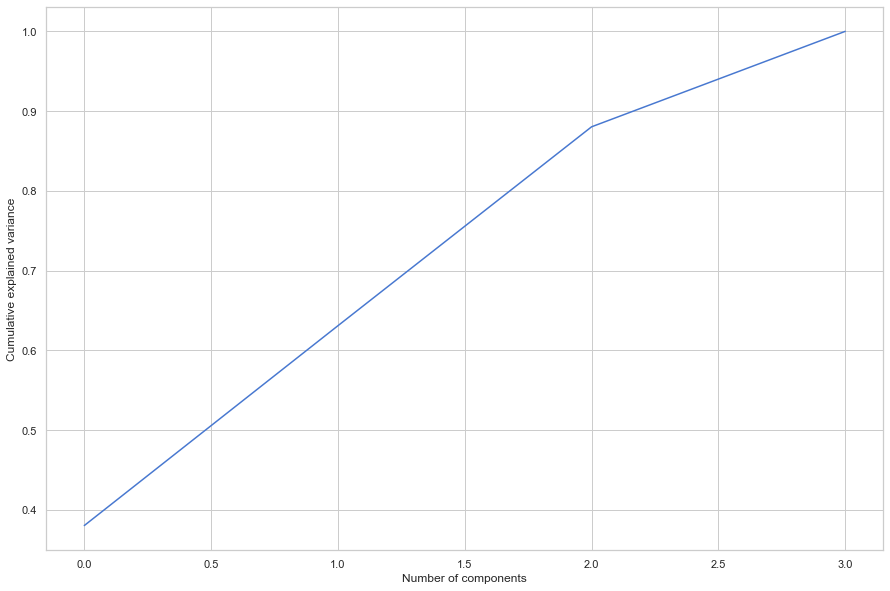

In [64]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(train_scaled)

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)


# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

Text(0, 0.5, 'Cumulative explained variance')

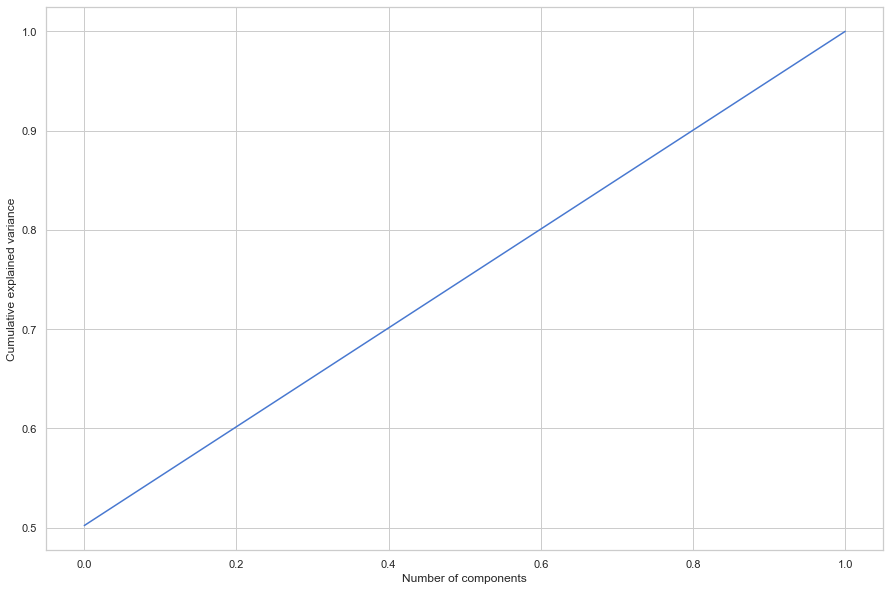

In [65]:
# define PCA object
pca = PCA()

# fit the PCA model to our data and apply the dimensionality reduction 
prin_comp = pca.fit_transform(test_scaled)

# create a dataframe containing the principal components
pca_df = pd.DataFrame(data = prin_comp)


# plot line graph of cumulative variance explained
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

In [66]:
pca_85 = PCA(.85)
pca_85.fit_transform(train_scaled)
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

88.0 % of variance explained by 3 components.


In [67]:
pca.explained_variance_ratio_[:3]

array([0.50220069, 0.49779931])

In [68]:
pca_85 = PCA(.85)
pca_85.fit_transform(test_scaled)
print(round(pca_85.explained_variance_ratio_.sum()*100, 1),
      "% of variance explained by",
      pca_85.n_components_,
      "components.")

100.0 % of variance explained by 2 components.


In [69]:
pca.explained_variance_ratio_[:3]

array([0.50220069, 0.49779931])

## 2. Data Engineering

In [70]:
X = train[features].drop(columns=['rating'])
y = train['rating']

In [71]:
# create scaler object
scaler = StandardScaler()

# define scaled data frame variable

X_scaled = preprocessing.scale(X)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

### Clustering

In [73]:
# create PCA object with n_components set to 13
pca_reg = PCA(n_components=2)

# fit the PCA model to our data and apply the dimensionality reduction 
X_train = pca_reg.fit_transform(X_train)

# confirm the number of components
pca_reg.n_components_

2

In [74]:
pca_reg.explained_variance_ratio_.sum()

1.0

## 3. Modeling

#### Linear Model 

In [75]:
# instantiate model with 1000 decision trees
lr = LinearRegression()

# train the model on training data
lr.fit(X_train, y_train)

LinearRegression()

In [76]:
# use the forest's predict method on the test data
predictions = lr.predict(X_test)

# calculate the absolute errors
errors = abs(predictions - y_test)

# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.84


C:\Users\Leham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but LinearRegression was fitted without feature names



In [77]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leham-greeves/unsupervised-learning-js7/957a4f069b934dd6abdd61499d62b768
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Uploading 1 metrics, params and output messages


#### Decision Tree Regression

In [78]:
# instantiate model with 1000 decision trees
dt = DecisionTreeRegressor(max_depth = 100)

# train the model on training data
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=100)

In [79]:
# use the forest's predict method on the test data
pred_dt = dt.predict(X_test)

# calculate the absolute errors
errors = abs(pred_dt - y_test)
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

C:\Users\Leham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:443: UserWarning:

X has feature names, but DecisionTreeRegressor was fitted without feature names



Mean Absolute Error: 1.07


#### Random Forest 

In [80]:
"""# instantiate model with 1000 decision trees
rf = RandomForestRegressor(max_depth = 10)

# train the model on training data
rf.fit(X_train, y_train)"""

'# instantiate model with 1000 decision trees\nrf = RandomForestRegressor(max_depth = 10)\n\n# train the model on training data\nrf.fit(X_train, y_train)'

In [81]:
"""# use the forest's predict method on the test data
pred_rf = rf.predict(X_test)

# calculate the absolute errors
errors = abs(pred_rf - y_test)

# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))"""

"# use the forest's predict method on the test data\npred_rf = rf.predict(X_test)\n\n# calculate the absolute errors\nerrors = abs(pred_rf - y_test)\n\n# print out the mean absolute error (mae)\nprint('Mean Absolute Error:', round(np.mean(errors), 2))"

#### Test Predictions

In [82]:
X_test = pca_reg.transform(test_scaled)

C:\Users\Leham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [83]:
predictions = lr.predict(X_test)

In [84]:
pred_dt = dt.predict(X_test)

In [85]:
"""pred_rf = rf.predict(X_test)"""

'pred_rf = rf.predict(X_test)'

In [86]:
# Create an experiment with your api key
experiment = Experiment(
    api_key="psoOiCbkWwyhnu0F19cN7s7SR",
    project_name="unsupervised-learning-js7",
    workspace="leham-greeves",
)

# Run your code and go to /

COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.com/leham-greeves/unsupervised-learning-js7/1e09328edfac45ffaa84b86990a6ca06

COMET INFO: Couldn't find a Git repository in 'c:\\Users\\Leham\\OneDrive\\Documents\\GitHub\\edsa-movie-recommendation-2022' nor in any parent directory. You can override where Comet is looking for a Git Patch by setting the configuration `COMET_GIT_DIRECTORY`


### Multi-Dimensional Scaling

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [96]:
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, 
                   n_init=4, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
X_mds = clf.fit_transform(X_train[:5000])

Computing MDS embedding


In [97]:
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, 
                   n_init=4, 
                   max_iter=200,
                   n_jobs=-1,
                   random_state=42,
                   dissimilarity='euclidean')
X_mds = clf.fit_transform(test_scaled[:5000])

Computing MDS embedding


#### T-SNE 

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2)

In [99]:
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2,
                     perplexity=40,
                     metric='euclidean',
                     init='pca',
                     verbose=1,
                     random_state=42)
X_tsne = tsne.fit_transform(X_train[:5000])

Computing t-SNE embedding
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.021s...


C:\Users\Leham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:805: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



[t-SNE] Computed neighbors for 5000 samples in 0.207s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.031334


C:\Users\Leham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\manifold\_t_sne.py:991: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



[t-SNE] KL divergence after 250 iterations with early exaggeration: 58.552162
[t-SNE] KL divergence after 1000 iterations: 0.491064


### K-means Clustering

#### Linear Regression

In [100]:
# instantiate model with 1000 decision trees
lr = LinearRegression()

# train the model on training data
lr.fit(X_train, y_train)

LinearRegression()

In [101]:
# use the forest's predict method on the test data
predictions = lr.predict(X_test)

# calculate the absolute errors
errors = abs(predictions - y_test)

# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 0.84


### Decision Trees

In [102]:
# instantiate model with 1000 decision trees
dt = DecisionTreeRegressor(max_depth = 100)

# train the model on training data
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=100)

In [103]:
# use the forest's predict method on the test data
pred_dt = dt.predict(X_test)

# calculate the absolute errors
errors = abs(pred_dt - y_test)
# print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.03


#### Test Predictions

In [104]:
X_test = pca_reg.transform(test_scaled)

C:\Users\Leham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



In [105]:
predictions = lr.predict(X_test)

In [106]:
pred_dt = dt.predict(X_test)

In [107]:
experiment.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/leham-greeves/unsupervised-learning-js7/1e09328edfac45ffaa84b86990a6ca06
COMET INFO:   Uploads:
COMET INFO:     environment details : 1
COMET INFO:     filename            : 1
COMET INFO:     installed packages  : 1
COMET INFO:     notebook            : 1
COMET INFO:     source_code         : 1
COMET INFO: ---------------------------
COMET WARNING: Comet has disabled auto-logging functionality as it has been imported after the following ML modules: sklearn. Metrics and hyperparameters can still be logged using comet_ml.log_metrics() and comet_ml.log_parameters()
COMET INFO: Uploading 1 metrics, params and output messages


## 4. Kaggle Submission 

In [108]:
Id = test.apply(lambda x:'%s_%s' % (x['userId'],x['movieId']),axis=1)

#### Linear Model

In [109]:
output = pd.DataFrame(predictions, columns = ['rating'])
id = pd.DataFrame(Id, columns = ['id'])
output = id.join(output)


In [110]:
output.to_csv('submission.csv', index = False)

output

,id,rating
0,1_2011,405.365720
1,1_4144,405.365194
2,1_5767,405.364794
3,1_6711,405.364561
4,1_7318,405.364411
...,...,...
5000014,162541_4079,405.356861
5000015,162541_4467,405.356765
5000016,162541_4980,405.356639
5000017,162541_5689,405.356464


#### Decision Tree Regressor 

In [111]:
decision_output = pd.DataFrame(pred_dt, columns = ['rating'])
decision_output = id.join(decision_output)

In [112]:
decision_output.to_csv('decision_submission.csv', index = False)

decision_output

,id,rating
0,1_2011,4.5
1,1_4144,4.5
2,1_5767,4.5
3,1_6711,4.5
4,1_7318,4.5
...,...,...
5000014,162541_4079,4.5
5000015,162541_4467,4.5
5000016,162541_4980,4.5
5000017,162541_5689,4.5


#### Random Forest

In [113]:
"""random_output = pd.DataFrame(pred_rf, columns = ['rating'])
random_output = id.join(random_output)"""

"random_output = pd.DataFrame(pred_rf, columns = ['rating'])\nrandom_output = id.join(random_output)"

In [114]:
"""random_output.to_csv('random_submission.csv', index = False)

random_output"""

"random_output.to_csv('random_submission.csv', index = False)\n\nrandom_output"